## Covariances and correlations
This notebook continues where [the previous notebook dedicated to volatilities](https://github.com/ilchen/RMaFI/blob/master/ch10.ipynb) left off. Even though estimating and forecasting covariances is similar to volatilities, there are important nuances.

The most important is how do we estimate λ for EMWA and ω, α, and β for GARCH(1, 1) so that resultant variance-covariance matrices are consistent? The way to do it to use the λ parameter that in aggregate works best for the variances. In other words, if we wan to measure volatilities and correlation for two assets, we should implement EWMA constraining λ to be the same for the two variances and choose the λ that maximizes the total of the two likelihoods as given by equation (10.13). It implies that we don't consider maximizing the likelihood for covariance estimations, only for variances.

To accomplish this I modified [the volatility parameters estimator classes](https://github.com/ilchen/RMaFI/blob/master/volatility/parameter_estimators.py) so that they can take prices for multiple assets and use the maximum likelihood method that maximizes the total of the likelihoods.

I also created [classes to track and forecast covariances](https://github.com/ilchen/RMaFI/blob/master/correlations/covariance_trackers.py). Once you can track covariances and volatilities, you can easily translate that into correlations. Since all my tracker classes use Panda DataFrames and Series, it all works seamlessly.

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime
from volatility import parameter_estimators
from volatility import volatility_trackers
from correlations import covariance_trackers

In [2]:
start = datetime.datetime(2019, 12, 15)
end = datetime.datetime.today()

### Estimating  correlation between SP500, Bitcoin, and Gold using EWMA
As I expained above, we'll need to search for a λ that maximizes the likelihood of witnessing the percentage changes of both SP500, Bitcoin and Gold.

In [3]:
data = web.get_data_yahoo(['^GSPC', 'BTC-USD', 'GC=F'], start, end)
asset_prices = data['Adj Close']

# We need to drop NaN rows as not all assets trade every day like BTC
asset_prices_sp500 = asset_prices['^GSPC'].dropna()
asset_prices_btc = asset_prices['BTC-USD'].dropna()
asset_prices_gold = asset_prices['GC=F'].dropna()

In [4]:
# Searching for a λ that maximizes the likelihood of witnessing the percentage changes of both SP500, BTC and Gold
combined_ewma = parameter_estimators.EWMAParameterEstimator(asset_prices)

# Reusing it to track the volatilities of these two assets and their covariane 
sp500_vol_tracker = volatility_trackers.EWMAVolatilityTracker(combined_ewma.lamda, asset_prices_sp500)
btc_vol_tracker = volatility_trackers.EWMAVolatilityTracker(combined_ewma.lamda, asset_prices_btc)
gold_vol_tracker = volatility_trackers.EWMAVolatilityTracker(combined_ewma.lamda, asset_prices_gold)

# Covariance between SP500 and BTC
covariance_tracker_sp500_btc = covariance_trackers.EWMACovarianceTracker(combined_ewma.lamda, asset_prices[['^GSPC', 'BTC-USD']])

# Covariance between SP500 and Gold
covariance_tracker_sp500_gold = covariance_trackers.EWMACovarianceTracker(combined_ewma.lamda, asset_prices[['^GSPC', 'GC=F']])

Objective function: 14537.57801 after 13 iterations


In [5]:
print('\u03BB that maximizes the likelihood of percentage changes in SP500, BTC-USD, and Gold: %.7f'
      % combined_ewma.lamda)

λ that maximizes the likelihood of percentage changes in SP500, BTC-USD, and Gold: 0.8965343


Correlation can be obtained by dividing the covariance by a product of daily volatilities (daily standard deviations). Pandas Series objects make this trivial.

In [6]:
sp500_vols = sp500_vol_tracker.get_daily_volatilities()
btc_vols = btc_vol_tracker.get_daily_volatilities()
gold_vols = gold_vol_tracker.get_daily_volatilities()
covariances_sp500_btc = covariance_tracker_sp500_btc.get_covariances()
correlations_sp500_btc = covariances_sp500_btc / (sp500_vols * btc_vols)
correlations_sp500_btc.dropna(inplace=True)

covariances_sp500_gold = covariance_tracker_sp500_gold.get_covariances()
correlations_sp500_gold = covariances_sp500_gold / (sp500_vols * gold_vols)
correlations_sp500_gold.dropna(inplace=True)

### Visualizing the correlation between SP500, Bitcoin, and Gold using EWMA
Since I would like to also show the closing prices, I need to scale them to 1 at the start of the timeseries so that I can map them both on the right y axis.

In [7]:
rescaled_asset_prices_sp500 = sp500_vol_tracker.get_adj_close_prices_for_dates(covariance_tracker_sp500_btc.get_dates()) / asset_prices_sp500[0]
rescaled_asset_prices_btc = btc_vol_tracker.get_adj_close_prices_for_dates(covariance_tracker_sp500_btc.get_dates()) / asset_prices_btc[0]
rescaled_asset_prices_gold = gold_vol_tracker.get_adj_close_prices_for_dates(covariance_tracker_sp500_gold.get_dates()) / asset_prices_gold[0]

In [8]:
assert len(rescaled_asset_prices_sp500) == len(rescaled_asset_prices_btc) == len(rescaled_asset_prices_gold)
assert len(covariance_tracker_sp500_btc.get_dates()) == len(covariance_tracker_sp500_gold.get_dates())
assert len(rescaled_asset_prices_sp500) == len(covariance_tracker_sp500_btc.get_dates())

Text(0, 0.5, 'Closing Price (scaled to 1)')

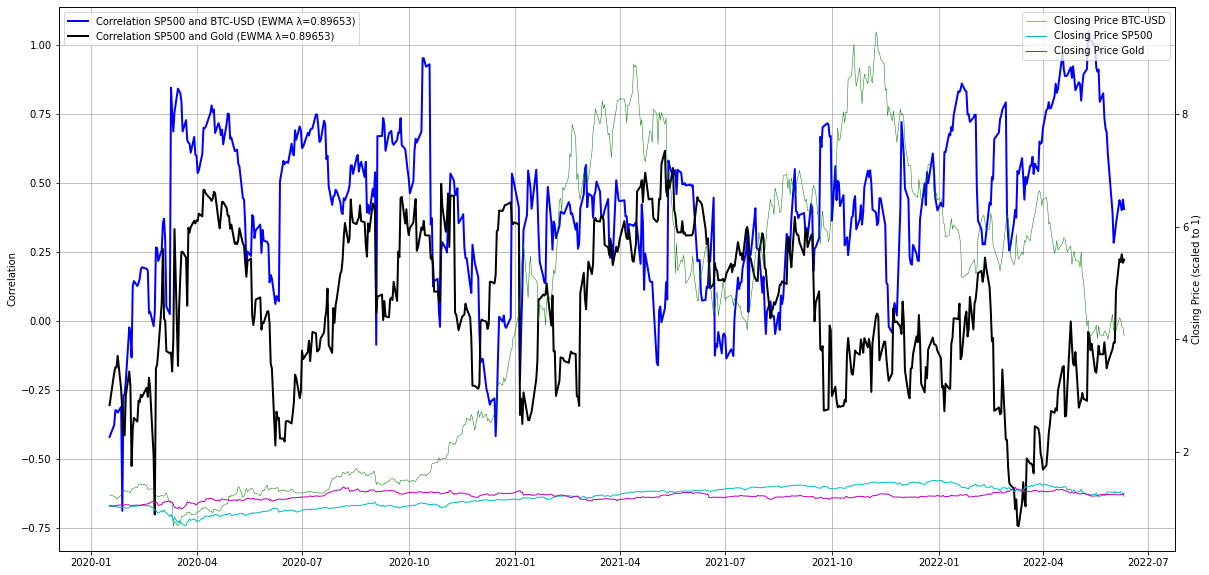

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

left_lbl, right_lbl = 'Correlation', 'Closing Price'

x = covariance_tracker_sp500_btc.get_dates()[20:] # Skipping the first 20 datapoints
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, correlations_sp500_btc[20:],
        label='Correlation SP500 and BTC-USD (EWMA λ=%.5f)' % combined_ewma.lamda , linewidth=2, color='b')
ax.plot(x, correlations_sp500_gold[20:],
        label='Correlation SP500 and Gold (EWMA λ=%.5f)' % combined_ewma.lamda , linewidth=2, color='k')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, rescaled_asset_prices_btc[20:], label=right_lbl + ' BTC-USD', linewidth=.5, color='g')
ax2.plot(x, rescaled_asset_prices_sp500[20:], label=right_lbl + ' SP500', linewidth=1, color='c')
ax2.plot(x, rescaled_asset_prices_gold[20:], label=right_lbl + ' Gold', linewidth=1, color='m')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.grid(True)
ax.set_ylabel(left_lbl)
ax2.set_ylabel(right_lbl + ' (scaled to 1)')

**NB:** a coefficient of correlation cannot exceed 1.0 by definition. The spike above 1 in the first days of the timeseries is a result of the first estimates of volatility and covariance being highly biased from their actual expectations.

### Visualizing volatility of SP500, Bitcoin, and Gold using EWMA

Text(0, 0.5, 'Annual Volatility')

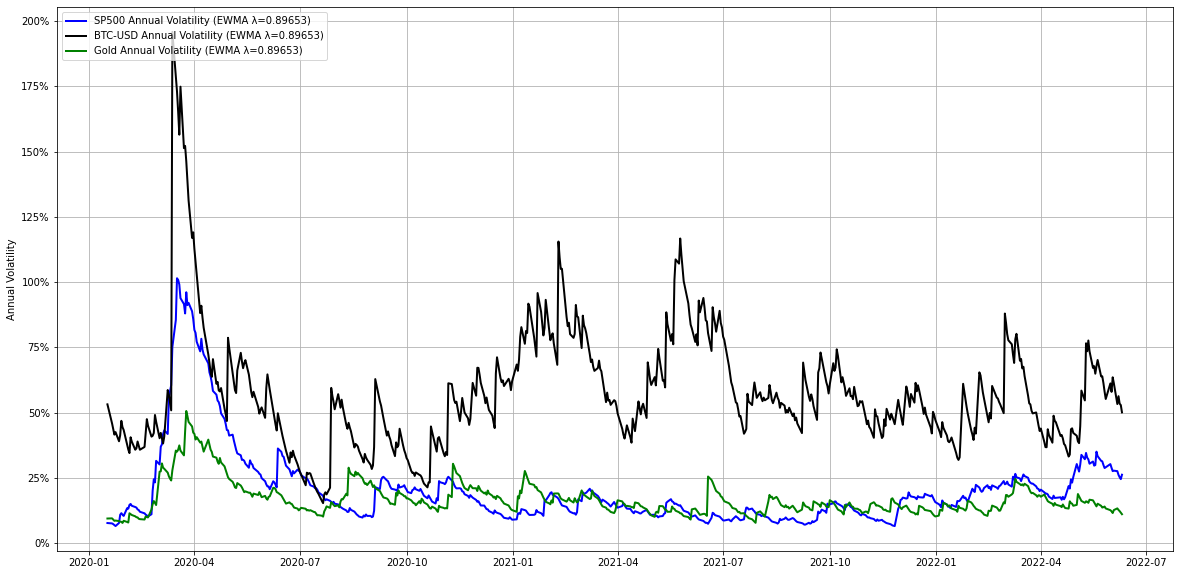

In [10]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, sp500_vol_tracker.get_annual_volatilities_for_dates(x) * 100,
        label='SP500 Annual Volatility (EWMA λ=%.5f)' % combined_ewma.lamda , linewidth=2, color='b')
ax.plot(x, btc_vol_tracker.get_annual_volatilities_for_dates(x) * 100,
        label='BTC-USD Annual Volatility (EWMA λ=%.5f)' % combined_ewma.lamda , linewidth=2, color='k')
ax.plot(x, gold_vol_tracker.get_annual_volatilities_for_dates(x) * 100,
        label='Gold Annual Volatility (EWMA λ=%.5f)' % combined_ewma.lamda , linewidth=2, color='g')

ax.legend(loc='upper left')
ax.grid(True)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Annual Volatility')

### Estimating correlation between Apple and SP500 using GARCH(1, 1)
Searching for ω, α, and β that maximize the likelihood of witnessing the given percentage changes in AAPL and SP500.

In [11]:
data = web.get_data_yahoo(['AAPL', '^GSPC'], start, end)
asset_prices = data['Adj Close']
asset_prices_apple = asset_prices['AAPL']

# Searching for ω, α, and β that maximize the likelihood of witnessing the given percentage
# changes in AAPL and SP500.
combined_garch = parameter_estimators.GARCHParameterEstimator(asset_prices)

# Reusing the ω, α, and β found
sp500_vol_tracker = volatility_trackers.GARCHVolatilityTracker(
    combined_garch.omega, combined_garch.alpha, combined_garch.beta, asset_prices_sp500)
apple_vol_tracker = volatility_trackers.GARCHVolatilityTracker(
    combined_garch.omega, combined_garch.alpha, combined_garch.beta, asset_prices_apple)
covariance_tracker = covariance_trackers.GARCHCovarianceTracker(
    combined_garch.omega, combined_garch.alpha, combined_garch.beta, asset_prices)

/usr/local/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Objective function: 9148.64810 after 119 iterations


Making an attempt to forecast future correlation between AAPL and SP500

In [12]:
sp500_vols = sp500_vol_tracker.get_daily_volatilities()
apple_vols = apple_vol_tracker.get_daily_volatilities()
covariances = covariance_tracker.get_covariances()
correlations = covariances / (sp500_vols * apple_vols)

# Forecasting correlation between Apple and SP500 200 days into the future
future_sp500_vols = sp500_vol_tracker.get_volatility_forecast_for_next_n_days(200)
future_apple_vols = apple_vol_tracker.get_volatility_forecast_for_next_n_days(200)
future_covariances = covariance_tracker.get_covariance_forecast_for_next_n_days(200)
future_correlations = future_covariances / (future_sp500_vols * future_apple_vols)

long_term_correlation = covariance_tracker.get_long_term_covariance() \
    / (sp500_vol_tracker.get_long_term_volatility() * apple_vol_tracker.get_long_term_volatility())

### Visualizing the correlation between AAPL and SP500 using GARCH(1, 1)

In [13]:
rescaled_asset_prices_apple = apple_vol_tracker.get_adj_close_prices() / asset_prices_apple[0]

Text(0, 0.5, 'Closing Price (scaled to 1)')

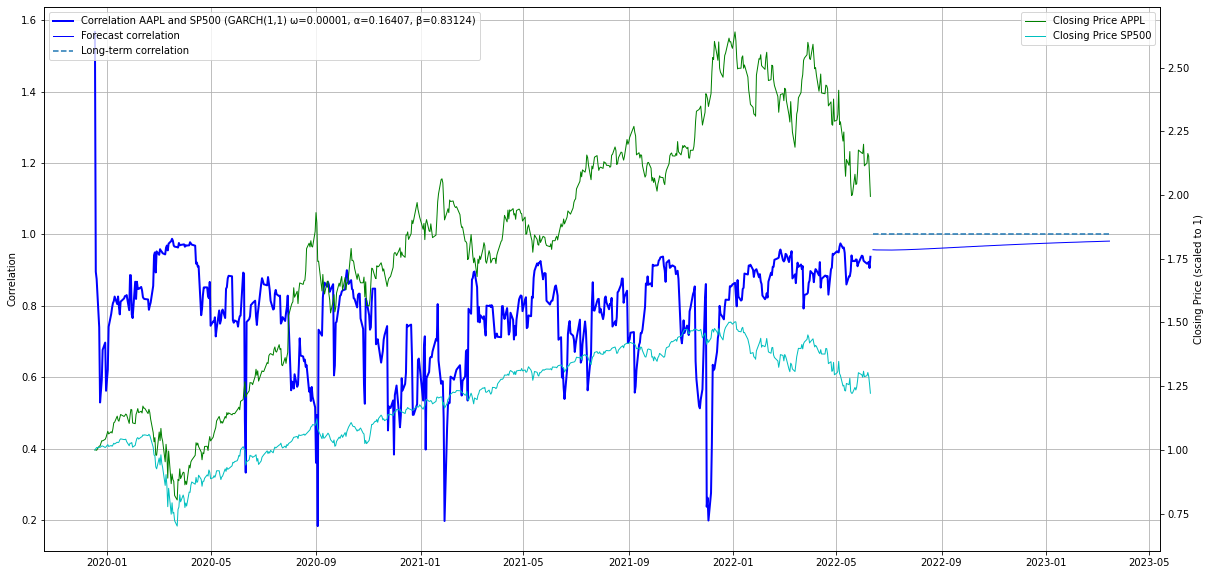

In [14]:
x = apple_vol_tracker.get_dates()
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, correlations,
        label='Correlation AAPL and SP500 (GARCH(1,1) ω=%.5f, α=%.5f, β=%.5f)'
            % (combined_garch.omega, combined_garch.alpha, combined_garch.beta),
        linewidth=2, color='b')

ax.plot(future_correlations.index, future_correlations, label='Forecast correlation', linewidth=1, color='b')
ax.hlines(long_term_correlation,
          xmin=future_correlations.index[0], xmax=future_correlations.index[-1],
         label="Long-term correlation", linestyle='--')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, rescaled_asset_prices_apple, label=right_lbl + ' APPL', linewidth=1, color='g')
ax2.plot(x, rescaled_asset_prices_sp500, label=right_lbl + ' SP500', linewidth=1, color='c')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.grid(True)
ax.set_ylabel(left_lbl)
ax2.set_ylabel(right_lbl + ' (scaled to 1)')

**NB:** The long-term correlation seems suspiciously close to 1.0. This is because by reusing the same ω, α, and β,  I ended up with the same long-term volatility estimate for AAPL and SP500:

In [15]:
print('Long-term volatility for AAPL: %.2f%%\nLong-term volatility for SP500: %.2f%%'
      % (apple_vol_tracker.get_annual_long_term_volatility() * 100,
         sp500_vol_tracker.get_annual_long_term_volatility() * 100))

Long-term volatility for AAPL: 58.68%
Long-term volatility for SP500: 58.68%


This obviously doesn't make sense, which shows that the GARCH(1, 1) model as presented in the textbook to update variance-covariane matrices is not correct. John C. Hull makes a note in Section _11.3 Correlation and Covariance Matroces_:
> Using a GARCH model to update a variance-covariance matrix in a consistent way is trickier and requires a multivariate model.